Loaded student-mat.csv
Shape: (395, 33)
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

--- EDA ---
               G1          G2      

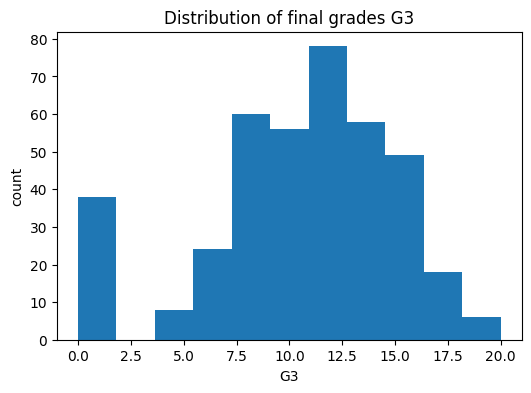

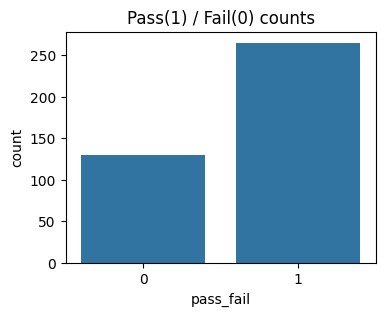


--- Regression evaluation ---
MSE: 5.656642833231222
RMSE: 2.3783697847961367
R2: 0.7241341236974022
Saved regression pipeline to student_g3_linear_reg.pkl

--- Evaluation: Logistic Regression ---
Accuracy: 0.8860759493670886
Precision: 0.9583333333333334
Recall: 0.8679245283018868
F1: 0.9108910891089109

Confusion Matrix:
 [[24  2]
 [ 7 46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.96      0.87      0.91        53

    accuracy                           0.89        79
   macro avg       0.87      0.90      0.88        79
weighted avg       0.90      0.89      0.89        79


--- Evaluation: Decision Tree ---
Accuracy: 0.8481012658227848
Precision: 0.9555555555555556
Recall: 0.8113207547169812
F1: 0.8775510204081632

Confusion Matrix:
 [[24  2]
 [10 43]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.92      

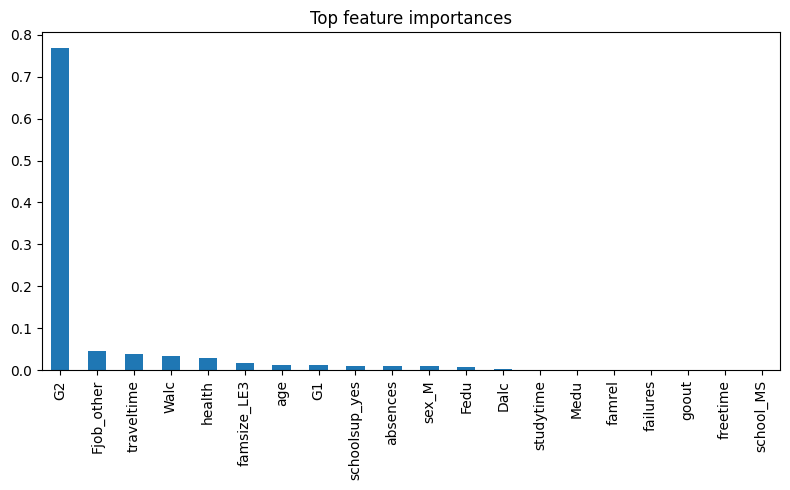


Wrote report_summary.txt


In [5]:
# Project: Student Performance Predictor
# Roll No: 23F-BSAI-AI
# Author: Farman Afzal
# Description: Jupyter-style Python script that builds two prediction tasks on the UCI Student Performance dataset:
# 1) Regression: predict final grade (G3) using Linear Regression
# 2) Classification: predict pass/fail using Logistic Regression and Decision Tree; compare metrics

# -------------------------
# 0. Install / Imports
# -------------------------

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import joblib

# -------------------------
# 1. Dataset loading
# -------------------------
# The UCI Student Performance dataset comes as two CSVs: student-mat.csv and student-por.csv.
# Download them from the UCI ML repository or from mirror GitHub repos and place next to this notebook.
# UCI: https://archive.ics.uci.edu/dataset/320/student+performance

mat_path = 'student-mat.csv'
por_path = 'student-por.csv'

if os.path.exists(mat_path):
    df = pd.read_csv(mat_path, sep=';')
    print('Loaded student-mat.csv')
elif os.path.exists(por_path):
    df = pd.read_csv(por_path, sep=';')
    print('Loaded student-por.csv')
else:
    raise FileNotFoundError("Place 'student-mat.csv' or 'student-por.csv' in the working directory. Download from UCI repository.")

# Quick peek
print('Shape:', df.shape)
print(df.head())

# -------------------------
# 2. Dataset description
# -------------------------
# The dataset contains demographic, social, school-related and grades information.
# Important numeric target: G3 (final grade). G1 and G2 are earlier grades.
# I'll create a pass/fail label: pass if G3 >= 10 (common threshold in literature), else fail.

# Create binary target
df['pass_fail'] = (df['G3'] >= 10).astype(int)

# -------------------------
# 3. Exploratory Data Analysis (brief)
# -------------------------
print('\n--- EDA ---')
print(df[['G1','G2','G3','studytime','absences','pass_fail']].describe())

# Correlation with G3 (numeric cols only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()['G3'].sort_values(ascending=False)
print('\nTop correlations with G3:\n', corr.head(10))

# Optional: plot histogram of G3 and class counts
plt.figure(figsize=(6,4))
plt.hist(df['G3'], bins=11)
plt.title('Distribution of final grades G3')
plt.xlabel('G3')
plt.ylabel('count')
plt.show()

plt.figure(figsize=(4,3))
sns.countplot(x='pass_fail', data=df)
plt.title('Pass(1) / Fail(0) counts')
plt.show()

# -------------------------
# 4. Preprocessing
# -------------------------
# Strategy:
# - Separate numerical and categorical features
# - Impute missing values (if any)
# - Scale numeric features with StandardScaler
# - OneHotEncode categorical features (drop='first' to avoid collinearity)

# Drop extremely correlated or leaky columns if desired. G1 and G2 are strong predictors of G3 and commonly kept.
# We'll keep G1 and G2 for regression but demonstrate models both with and without them later if needed.

X = df.drop(columns=['G3','pass_fail'])
y_reg = df['G3']
y_clf = df['pass_fail']

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_features, cat_features

# Build preprocessing transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, cat_features)
])

# -------------------------
# 5. Regression: Linear Regression to predict G3
# -------------------------
# Pipeline: preprocessing -> LinearRegression
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Fit
reg_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred = reg_pipeline.predict(X_test)
print('\n--- Regression evaluation ---')
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

# Save regression model
joblib.dump(reg_pipeline, 'student_g3_linear_reg.pkl')
print('Saved regression pipeline to student_g3_linear_reg.pkl')

# -------------------------
# 6. Classification: Logistic Regression vs Decision Tree
# -------------------------
# We'll reuse the preprocessor but target is pass_fail
clf_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

clf_pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

# Fit classifiers
clf_pipeline_lr.fit(X_train_c, y_train_c)
clf_pipeline_dt.fit(X_train_c, y_train_c)

# Predict
y_pred_lr = clf_pipeline_lr.predict(X_test_c)
y_pred_dt = clf_pipeline_dt.predict(X_test_c)

# Evaluate function
def evaluate_classification(y_true, y_pred, model_name='model'):
    print(f"\n--- Evaluation: {model_name} ---")
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))
    print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))
    print('\nClassification Report:\n', classification_report(y_true, y_pred))

# Show evaluations
evaluate_classification(y_test_c, y_pred_lr, 'Logistic Regression')
evaluate_classification(y_test_c, y_pred_dt, 'Decision Tree')

# Save classifiers
joblib.dump(clf_pipeline_lr, 'student_pass_logistic.pkl')
joblib.dump(clf_pipeline_dt, 'student_pass_dt.pkl')
print('Saved classification pipelines to student_pass_logistic.pkl and student_pass_dt.pkl')

# -------------------------
# 7. Feature importance (Decision Tree)
# -------------------------
# To show feature importance we need feature names after preprocessing
onehot_cols = list(reg_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features)) if hasattr(reg_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'], 'get_feature_names_out') else []
processed_feature_names = numeric_features + onehot_cols

# Extract feature importances from decision tree
try:
    dt = clf_pipeline_dt.named_steps['classifier']
    importances = dt.feature_importances_
    fi = pd.Series(importances, index=processed_feature_names).sort_values(ascending=False).head(20)
    print('\nTop feature importances (Decision Tree):')
    print(fi)
    plt.figure(figsize=(8,5))
    fi.plot(kind='bar')
    plt.title('Top feature importances')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Could not extract importances:', e)

# -------------------------
# 8. Conclusion / Next steps (to include in report)
 # -------------------------
# - The notebook trains a regression model for G3 and two classifiers for pass/fail.
# - Compare metrics: RMSE/R2 for regression; Accuracy/Precision/Recall/F1 for classification.

# -------------------------
# 9. Save a brief report file
# -------------------------
report = '''Student Performance Predictor\n
Preprocessing steps:\n- Numerical imputation with median and scaling (StandardScaler)\n- Categorical imputation with most frequent and OneHotEncoding (drop first)\n\nModels used:\n- Linear Regression for predicting G3 (final grade)\n- Logistic Regression and Decision Tree for pass/fail classification\n\nEvaluation:\n- Regression: MSE, RMSE, R2\n- Classification: Accuracy, Precision, Recall, F1, Confusion Matrix\n\nFiles produced: student_g3_linear_reg.pkl, student_pass_logistic.pkl, student_pass_dt.pkl\n'''
with open('report_summary.txt','w') as f:
    f.write(report)
print('\nWrote report_summary.txt')

